# Notebook 08 — Final Report (Anforderungen 1–9)

**Projekt:** Vorhersage der Fahrtdauer von Fahrradaktivitäten (Regression)  
**Zielvariable:** `moving_time` (Sekunden)

Dieses Notebook ist das **Abgabe- und Präsentations-Notebook** und bildet den roten Faden entlang der Anforderungen ab:

1. Problembeschreibung  
2. Datenquelle & Datenbeschreibung  
3. Explorative Datenanalyse (EDA)  
4. Datenvorverarbeitung / Quality Checks  
5. (Optional) Data Augmentation  
6. Modellauswahl & Hyperparameter  
7. Training  
8. Evaluation, Ergebnisse & Fehleranalyse  
9. Diskussion, Limitationen, Fazit & Next Steps  

## Datenquelle
Datensatz: *Outdoor cycling metrics* (Kaggle). Lizenzangabe auf Kaggle: **License unknown**.

## Reproduzierbarkeit (Projekt-Logik)
- Dieses Notebook lädt **Ergebnisse/Artefakte** aus `data_derived/` und `plots/`, die durch **Notebooks 01–06** erzeugt werden.
- Falls Dateien fehlen: bitte **Notebooks 01 → 06** der Reihe nach mit „Run All“ ausführen und danach dieses Notebook.
- Leakage-Regel: `elapsed_time` ist im Datensatz vorhanden, wird aber **nicht** als Feature genutzt.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

# Repo-Root robust bestimmen (funktioniert aus /notebooks oder Repo-Root)
CWD = Path.cwd()
REPO_ROOT = CWD.parent if CWD.name == "notebooks" else CWD

PATH_DATA = REPO_ROOT / "data"
PATH_RAW = PATH_DATA / "raw"
PATH_PROCESSED = PATH_DATA / "processed"
PATH_DERIVED = REPO_ROOT / "data_derived"
PATH_PLOTS = REPO_ROOT / "plots"

TARGET = "moving_time"
LEAKAGE_COLS = ["elapsed_time"]

def read_csv_safe(path: Path, required: bool = True) -> pd.DataFrame:
    if not path.exists():
        msg = f"[FEHLT] {path}"
        if required:
            raise FileNotFoundError(msg)
        print(msg)
        return pd.DataFrame()
    df = pd.read_csv(path)
    return df

def shape_or_empty(df: pd.DataFrame):
    return None if df is None or df.empty else df.shape

def pick_col(df: pd.DataFrame, candidates: list[str]) -> str | None:
    for c in candidates:
        if c in df.columns:
            return c
    return None

print("REPO_ROOT:", REPO_ROOT)
print("PATH_DERIVED:", PATH_DERIVED)
print("PATH_PLOTS:", PATH_PLOTS)

REPO_ROOT: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer
PATH_DERIVED: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived
PATH_PLOTS: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/plots


In [2]:
# Erwartete Artefakte aus 01–06
paths = {
    "processed.csv": PATH_PROCESSED / "processed.csv",
    "model_ready.csv": PATH_PROCESSED / "model_ready.csv",
    "03_cv_results_final_no_leak.csv": PATH_DERIVED / "03_cv_results_final_no_leak.csv",
    "04_holdout_metrics_no_leak.csv": PATH_DERIVED / "04_holdout_metrics_no_leak.csv",
    "05_holdout_metrics_histgbr.csv": PATH_DERIVED / "05_holdout_metrics_histgbr.csv",
    "05_holdout_predictions_histgbr.csv": PATH_DERIVED / "05_holdout_predictions_histgbr.csv",
    "06_permutation_importance_histgbr.csv": PATH_DERIVED / "06_permutation_importance_histgbr.csv",
}

# Load (required = True, weil Final Report ohne diese Artefakte nicht sinnvoll ist)
processed = read_csv_safe(paths["processed.csv"], required=True)
model_ready = read_csv_safe(paths["model_ready.csv"], required=True)
cv_no_leak = read_csv_safe(paths["03_cv_results_final_no_leak.csv"], required=True)
holdout_baseline = read_csv_safe(paths["04_holdout_metrics_no_leak.csv"], required=True)
holdout_hist = read_csv_safe(paths["05_holdout_metrics_histgbr.csv"], required=True)
pred_hist = read_csv_safe(paths["05_holdout_predictions_histgbr.csv"], required=True)
perm = read_csv_safe(paths["06_permutation_importance_histgbr.csv"], required=True)

# Übersicht
artifact_index = pd.DataFrame([{
    "artifact": name,
    "exists": p.exists(),
    "shape": read_csv_safe(p, required=False).shape if p.exists() else None
} for name, p in paths.items()])

display(artifact_index)

# QC: Leakage-Spalte vorhanden?
leak_present = [c for c in LEAKAGE_COLS if c in model_ready.columns]
print("Leakage-Spalten in model_ready vorhanden (nicht als Feature nutzen):", leak_present)

# Hold-out Plausibilität (sollte ~20% sein)
print("model_ready rows:", len(model_ready), "| holdout preds rows:", len(pred_hist),
      "| holdout share:", f"{len(pred_hist)/len(model_ready):.3f}")

,artifact,exists,shape
0,processed.csv,True,"(9948, 6)"
1,model_ready.csv,True,"(9237, 13)"
2,03_cv_results_final_no_leak.csv,True,"(3, 7)"
3,04_holdout_metrics_no_leak.csv,True,"(1, 7)"
4,05_holdout_metrics_histgbr.csv,True,"(1, 7)"
5,05_holdout_predictions_histgbr.csv,True,"(1848, 10)"
6,06_permutation_importance_histgbr.csv,True,"(7, 3)"


Leakage-Spalten in model_ready vorhanden (nicht als Feature nutzen): ['elapsed_time']
model_ready rows: 9237 | holdout preds rows: 1848 | holdout share: 0.200


## Executive Summary (Ergebnisse in 3 Zeilen)

Die folgenden Zahlen stammen aus den gespeicherten Artefakten (`data_derived/*.csv`) und sind damit direkt reproduzierbar.

- **CV (Train, no-leak):** bestes Baseline-Modell (nach CV-MAE)
- **Hold-out (no-leak):** Baseline-Leistung auf dem Test-Split
- **Hold-out (HistGBR):** erweiterter Ansatz mit Feature Engineering + HistGBR

Interpretation: HistGBR reduziert den Hold-out-Fehler gegenüber der Baseline deutlich und wird deshalb als finaler Ansatz für die weitere Analyse verwendet (Fehleranalyse, Wichtigkeiten, Limitationen).

In [3]:
# --- CV: bestes Baseline-Modell robust bestimmen ---
cv_mae_col = pick_col(cv_no_leak, ["mae_mean_s", "mae_mean", "mae_cv_mean_s", "mae"])
cv_rmse_col = pick_col(cv_no_leak, ["rmse_mean_s", "rmse_mean", "rmse_cv_mean_s", "rmse"])
cv_r2_col = pick_col(cv_no_leak, ["r2_mean", "r2_cv_mean", "r2"])

if cv_mae_col is None:
    raise ValueError(f"Keine MAE-Spalte in CV-Results gefunden. Spalten: {list(cv_no_leak.columns)}")

cv_best = cv_no_leak.sort_values(cv_mae_col, ascending=True).iloc[0]
cv_best_model = str(cv_best.get("model", "CV-Baseline"))
cv_best_mae = float(cv_best[cv_mae_col])
cv_best_rmse = float(cv_best[cv_rmse_col]) if cv_rmse_col else np.nan
cv_best_r2 = float(cv_best[cv_r2_col]) if cv_r2_col else np.nan

# --- Hold-out Baseline ---
b = holdout_baseline.iloc[0]
b_model = str(b.get("model", "Hold-out Baseline"))
b_mae = float(b.get("mae_s"))
b_rmse = float(b.get("rmse_s"))
b_r2 = float(b.get("r2"))

# --- Hold-out HistGBR ---
h = holdout_hist.iloc[0]
h_model = str(h.get("model", "HistGBR"))
h_mae = float(h.get("mae_s"))
h_rmse = float(h.get("rmse_s"))
h_r2 = float(h.get("r2"))

exec_summary = pd.DataFrame([
    {
        "block": "CV (no-leak) – Baseline-Sieger",
        "model": cv_best_model,
        "mae_s": cv_best_mae,
        "rmse_s": cv_best_rmse,
        "r2": cv_best_r2,
        "mae_min": cv_best_mae / 60.0,
        "rmse_min": cv_best_rmse / 60.0 if not np.isnan(cv_best_rmse) else np.nan,
    },
    {
        "block": "Hold-out – Baseline (no-leak)",
        "model": b_model,
        "mae_s": b_mae,
        "rmse_s": b_rmse,
        "r2": b_r2,
        "mae_min": b_mae / 60.0,
        "rmse_min": b_rmse / 60.0,
    },
    {
        "block": "Hold-out – Erweiterter Ansatz (HistGBR)",
        "model": h_model,
        "mae_s": h_mae,
        "rmse_s": h_rmse,
        "r2": h_r2,
        "mae_min": h_mae / 60.0,
        "rmse_min": h_rmse / 60.0,
    },
])

display(exec_summary)

improvement_s = b_mae - h_mae
improvement_pct = improvement_s / b_mae * 100.0
print(f"Interpretation: HistGBR reduziert den Hold-out-MAE um {improvement_s:.0f}s ({improvement_pct:.1f}%).")

out_path = PATH_DERIVED / "80_executive_summary.csv"
exec_summary.to_csv(out_path, index=False)
print("Saved:", out_path)

,block,model,mae_s,rmse_s,r2,mae_min,rmse_min
0,CV (no-leak) – Baseline-Sieger,"Ridge (degree=1, alpha=0.1) [BEST]",760.562772,1467.069287,0.917594,12.676046,24.451155
1,Hold-out – Baseline (no-leak),"Ridge (degree=1, alpha=0.1)",760.643263,1631.394177,0.898263,12.677388,27.189903
2,Hold-out – Erweiterter Ansatz (HistGBR),HistGBR depth=6 lr=0.03 it=600,605.110089,1452.820821,0.919316,10.085168,24.213680


Interpretation: HistGBR reduziert den Hold-out-MAE um 156s (20.4%).
Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/80_executive_summary.csv


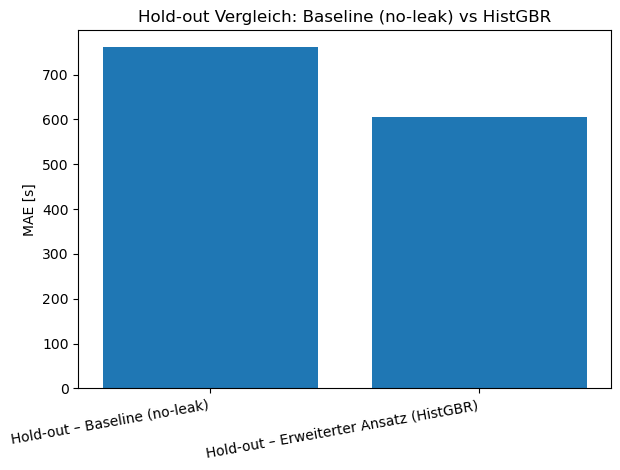

Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/plots/08_holdout_mae_comparison.png


In [4]:
plot_df = exec_summary[exec_summary["block"].str.contains("Hold-out")].copy()
plot_df = plot_df.sort_values("mae_s", ascending=False)

plt.figure()
plt.bar(plot_df["block"], plot_df["mae_s"])
plt.ylabel("MAE [s]")
plt.title("Hold-out Vergleich: Baseline (no-leak) vs HistGBR")
plt.xticks(rotation=10, ha="right")
plt.tight_layout()
out_plot = PATH_PLOTS / "08_holdout_mae_comparison.png"
plt.savefig(out_plot, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", out_plot)

## 1) Problem und Zielsetzung

Ziel ist die Vorhersage der Fahrtdauer einer Fahrradaktivität (**Regression**) auf Basis weniger, robuster Streckenmerkmale.
Die Zielvariable ist `moving_time` (Sekunden). 

Praktischer Nutzen:
- Erwartungsmanagement („Wie lange dauert die Fahrt?“) auf Basis geplanter Strecke und Höhenprofil.

## 2) Datenquelle und Datenbeschreibung

Datenquelle: Kaggle-Datensatz *Outdoor cycling metrics*.  
Die Rohdaten liegen lokal in `data/raw/`, werden aber nicht versioniert.  
Die weiteren Schritte erzeugen:
- `data/processed/processed.csv` (bereinigt)
- `data/processed/model_ready.csv` (Scope + Feature Engineering)

## 3) Leakage-Regel (wichtig für Modellierung)

`elapsed_time` ist in den Daten vorhanden, wird aber **nicht** als Feature genutzt.
Begründung: `elapsed_time` enthält Informationen, die der Zielvariable `moving_time` sehr nahe sind und würde die Modellgüte künstlich erhöhen (Leakage).

In [5]:
overview = pd.DataFrame([{
    "processed_rows": int(processed.shape[0]),
    "processed_cols": int(processed.shape[1]),
    "model_ready_rows": int(model_ready.shape[0]),
    "model_ready_cols": int(model_ready.shape[1]),
    "target_present_in_model_ready": int(TARGET in model_ready.columns),
    "elapsed_time_present_in_model_ready": int("elapsed_time" in model_ready.columns),
}])

display(overview)

out_path = PATH_DERIVED / "84_scope_summary.csv"
overview.to_csv(out_path, index=False)
print("Saved:", out_path)

,processed_rows,processed_cols,model_ready_rows,model_ready_cols,target_present_in_model_ready,elapsed_time_present_in_model_ready
0,9948,6,9237,13,1,1


Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/84_scope_summary.csv


In [6]:
# numerische Korrelationen zu moving_time (nur als Orientierung)
num_cols = model_ready.select_dtypes(include=[np.number]).columns.tolist()
if TARGET not in num_cols:
    raise ValueError(f"{TARGET} ist nicht numerisch in model_ready.csv – Spalten prüfen.")

corr = (
    model_ready[num_cols]
    .corr(numeric_only=True)[TARGET]
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"index": "feature", TARGET: "corr_with_target"})
)

# Leakage-Spalten markieren (nur Hinweis, nicht als Feature nutzen)
corr["is_leakage"] = corr["feature"].isin(LEAKAGE_COLS)

display(corr.head(10))

out_path = PATH_DERIVED / "83_eda_top_correlations.csv"
corr.to_csv(out_path, index=False)
print("Saved:", out_path)

,feature,corr_with_target,is_leakage
0,moving_time,1.000000,False
1,distance,0.951414,False
2,distance_km,0.951414,False
3,total_elevation_gain,0.784821,False
4,elev_range,0.394293,False
5,highest_elevation,0.383764,False
6,elapsed_time,0.310644,True
7,elev_gain_per_km,0.258448,False
8,pace_min_per_km,0.084442,False
9,stop_time,0.057522,False


Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/83_eda_top_correlations.csv


## Interpretierbarkeit: Permutation Importance (HistGBR)

Zur Interpretation verwenden wir Permutation Importance auf dem Hold-out Split.
Dabei messen wir, wie stark sich der Fehler verändert, wenn ein Feature zufällig permutiert wird.

- Positive Werte bedeuten: **Fehler steigt** → Feature ist wichtig.
- Werte nahe 0 bedeuten: Feature ist redundant oder wenig informativ.

,feature,mae_increase_s,mae_increase_std_s
0,distance,3.552598e+03,7.319540e+01
1,total_elevation_gain,3.129089e+02,8.304094e+00
2,lowest_elevation,1.348852e+02,5.742689e+00
3,elev_range,8.508098e+01,4.130193e+00
4,highest_elevation,8.258916e+01,5.468960e+00
5,elev_gain_per_km,8.191886e+01,5.279971e+00
6,distance_km,-1.136868e-13,1.166402e-13


Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/89_permutation_importance_sorted.csv


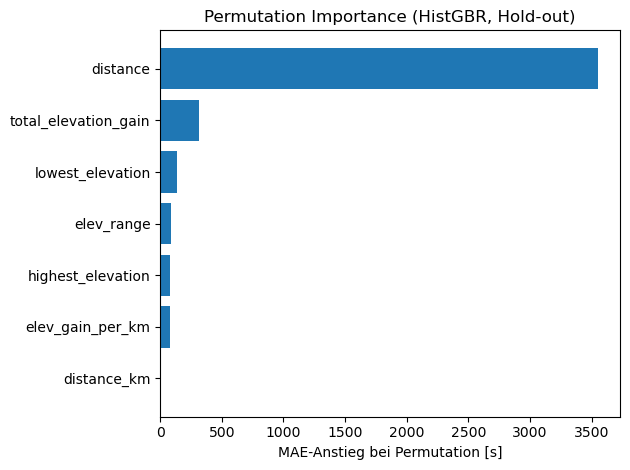

Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/plots/08_permutation_importance_histgbr.png
Top-Treiber: distance > total_elevation_gain > lowest_elevation | MAE-Anstieg [s]: 3552.6, 312.9, 134.9


In [7]:
# Erwartete Spalten: feature, mae_increase_s, mae_increase_std_s
req_cols = {"feature", "mae_increase_s", "mae_increase_std_s"}
if not req_cols.issubset(set(perm.columns)):
    raise ValueError(f"Permutation-CSV hat unerwartete Spalten: {list(perm.columns)}")

perm_sorted = perm.sort_values("mae_increase_s", ascending=False).reset_index(drop=True)
display(perm_sorted)

out_path = PATH_DERIVED / "89_permutation_importance_sorted.csv"
perm_sorted.to_csv(out_path, index=False)
print("Saved:", out_path)

# Plot (Top-down)
plt.figure()
plt.barh(perm_sorted["feature"][::-1], perm_sorted["mae_increase_s"][::-1])
plt.xlabel("MAE-Anstieg bei Permutation [s]")
plt.title("Permutation Importance (HistGBR, Hold-out)")
plt.tight_layout()
out_plot = PATH_PLOTS / "08_permutation_importance_histgbr.png"
plt.savefig(out_plot, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", out_plot)

top3 = perm_sorted.head(3)
drivers = " > ".join(top3["feature"].tolist())
print("Top-Treiber:", drivers, "| MAE-Anstieg [s]:", ", ".join([f"{v:.1f}" for v in top3["mae_increase_s"]]))

**Kurzinterpretation:**  
Die wichtigsten Treiber sind (nach Permutation Importance) typischerweise `distance` und danach Höhenprofil-Merkmale wie `total_elevation_gain`.  
Ein Feature mit Importance nahe 0 (z. B. `distance_km`) ist plausibel, wenn es redundant zu `distance` ist (starke Korrelation / gleiche Information in anderer Skalierung).

## Fehleranalyse (Hold-out, HistGBR)

Wir analysieren die absoluten Fehler (`abs_error_s`) auf dem Hold-out Split:
- Scatter: absoluter Fehler vs. Distanz
- Buckets nach Distanz (5–10 / 10–20 / 20–40 / 40–80 / 80+ km)
- Kennzahlen (Median, Mean, P90) pro Bucket


In [8]:
# Sicherheitscheck: benötigte Spalten in pred_hist
needed = {"distance_km", "y_true", "y_pred", "abs_error_s"}
missing = needed - set(pred_hist.columns)
if missing:
    raise ValueError(f"In 05_holdout_predictions_histgbr.csv fehlen Spalten: {missing}")

err_stats = pd.DataFrame([{
    "count": int(pred_hist.shape[0]),
    "mean_abs_error_s": float(pred_hist["abs_error_s"].mean()),
    "median_abs_error_s": float(pred_hist["abs_error_s"].median()),
    "p90_abs_error_s": float(pred_hist["abs_error_s"].quantile(0.90)),
    "p95_abs_error_s": float(pred_hist["abs_error_s"].quantile(0.95)),
    "p99_abs_error_s": float(pred_hist["abs_error_s"].quantile(0.99)),
    "max_abs_error_s": float(pred_hist["abs_error_s"].max()),
}])

display(err_stats)

out_path = PATH_DERIVED / "87_error_stats_abs_error.csv"
err_stats.to_csv(out_path, index=False)
print("Saved:", out_path)

,count,mean_abs_error_s,median_abs_error_s,p90_abs_error_s,p95_abs_error_s,p99_abs_error_s,max_abs_error_s
0,1848,605.110089,217.833602,1462.732001,2304.991967,5234.125769,36327.036049


Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/87_error_stats_abs_error.csv


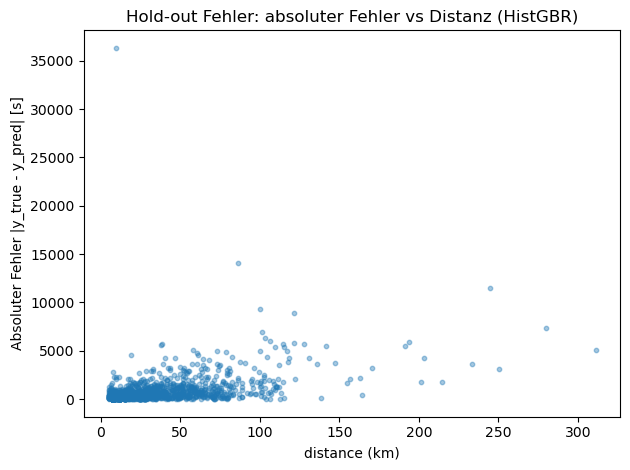

Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/plots/08_abs_error_vs_distance_scatter.png


In [9]:
plt.figure()
plt.scatter(pred_hist["distance_km"], pred_hist["abs_error_s"], s=10, alpha=0.4)
plt.xlabel("distance (km)")
plt.ylabel("Absoluter Fehler |y_true - y_pred| [s]")
plt.title("Hold-out Fehler: absoluter Fehler vs Distanz (HistGBR)")
plt.tight_layout()
out_plot = PATH_PLOTS / "08_abs_error_vs_distance_scatter.png"
plt.savefig(out_plot, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", out_plot)

In [10]:
bins = [5, 10, 20, 40, 80, np.inf]
labels = ["5–10", "10–20", "20–40", "40–80", "80+"]

tmp = pred_hist.copy()
tmp["distance_bucket_km"] = pd.cut(tmp["distance_km"], bins=bins, labels=labels, right=False)

bucket = (
    tmp.groupby("distance_bucket_km", observed=True)["abs_error_s"]
    .agg(
        count="count",
        median="median",
        mean="mean",
        p90=lambda x: float(np.quantile(x, 0.90)),
    )
    .reset_index()
)

display(bucket)

out_path = PATH_DERIVED / "88_error_buckets_by_distance.csv"
bucket.to_csv(out_path, index=False)
print("Saved:", out_path)

,distance_bucket_km,count,median,mean,p90
0,5–10,649,94.012364,222.428240,348.656799
1,10–20,422,185.867063,299.289656,709.389006
2,20–40,364,443.066982,630.296172,1368.199124
3,40–80,304,778.241975,1112.628719,2766.021620
4,80+,109,1782.937040,2568.076558,5720.108572


Saved: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/data_derived/88_error_buckets_by_distance.csv


## Diskussion und Limitationen

### Zentrale Erkenntnisse
- Der erweiterte Ansatz (HistGBR) verbessert die Hold-out-Performance gegenüber der Baseline (no-leak) deutlich (siehe Executive Summary).
- Die Modellvorhersage wird stark von `distance` und anschließend von Merkmalen des Höhenprofils beeinflusst (Permutation Importance).

### Fehlerbild (prüfbar aus der Bucket-Tabelle)
Die Fehler steigen mit zunehmender Distanz deutlich an:
- **5–10 km:** Median ≈ 94 s, P90 ≈ 349 s  
- **80+ km:** Median ≈ 1783 s, P90 ≈ 5720 s  

Interpretation:
- Lange Fahrten sind heterogener (Pausen, Verkehr, Ermüdung, Routen-/Oberflächenwechsel) und enthalten mehr nicht modellierte Einflüsse.
- Ein identisches Distanz-/Höhenprofil kann je nach Kontext sehr unterschiedliche `moving_time` erzeugen.

### Limitationen
- **Fehlende Kontext-Features:** Wetter, Wind, Verkehr, Untergrund, Ampeln sowie individuelle Fitness/Leistungsniveau sind nicht enthalten.
- **Tracking-/Recording-Artefakte:** Messungen (z. B. GPS-Glättung, fehlerhafte Höhenmeter) können Varianz erzeugen.
- **Verbleibende Stop-Logik:** Auch wenn wir `elapsed_time` nicht nutzen, kann das Stop-Verhalten (implizit) die Zielgröße stark beeinflussen.
- **Modellgrenzen:** Das Modell liefert Punktvorhersagen; Unsicherheit/Intervalle werden nicht quantifiziert.

## Next Steps (konkret)
1. **Kontext-Features ergänzen:** Wetter/Wind (API), Wochentag/Uhrzeit, Region/Routenprofil, ggf. Oberflächenklasse.
2. **Robustere Evaluation:** zusätzliche Splits (z. B. zeitbasiert oder nach Nutzer-ID, falls verfügbar) zur Generalisierung.
3. **Unsicherheit modellieren:** Quantile Regression / Prediction Intervals, um besonders lange Fahrten robuster abzudecken.
4. **Feature-Qualität verbessern:** Outlier-Handling für Höhenmeter, Plausibilitätschecks für implizite Geschwindigkeit.
5. **Alternative Zielmetrik ergänzen:** relativer Fehler (z. B. MAE pro km) oder Fehler in Minuten pro 10 km, um Längen fairer zu vergleichen.

## Fazit
- Eine **no-leak Baseline** liefert bereits gute Ergebnisse, aber HistGBR verbessert den Hold-out MAE deutlich.
- Der stärkste Treiber ist `distance`, danach Höhenprofil-Merkmale.
- Das Modell wird mit zunehmender Distanz deutlich ungenauer; lange Fahrten sind der wichtigste Verbesserungspunkt.
- Die nächsten Verbesserungen liegen vor allem in Kontextdaten, robusteren Splits und Unsicherheitsabschätzung.

In [11]:
final_artifacts = [
    PATH_DERIVED / "80_executive_summary.csv",
    PATH_DERIVED / "83_eda_top_correlations.csv",
    PATH_DERIVED / "84_scope_summary.csv",
    PATH_DERIVED / "87_error_stats_abs_error.csv",
    PATH_DERIVED / "88_error_buckets_by_distance.csv",
    PATH_DERIVED / "89_permutation_importance_sorted.csv",
    PATH_PLOTS / "08_holdout_mae_comparison.png",
    PATH_PLOTS / "08_permutation_importance_histgbr.png",
    PATH_PLOTS / "08_abs_error_vs_distance_scatter.png",
]

done = pd.DataFrame([{
    "artifact": p.name,
    "exists": p.exists(),
    "path": p.as_posix()
} for p in final_artifacts])

display(done)

missing = done.loc[done["exists"] == False, "artifact"].tolist()
if missing:
    raise FileNotFoundError(f"Final Report: erwartete Artefakte fehlen: {missing}")

print("Notebook 08 erfolgreich durchgelaufen. Alle erwarteten Artefakte sind vorhanden.")

,artifact,exists,path
0,80_executive_summary.csv,True,/Users/justuspfeifer/Documents/AML/aml-justus-...
1,83_eda_top_correlations.csv,True,/Users/justuspfeifer/Documents/AML/aml-justus-...
2,84_scope_summary.csv,True,/Users/justuspfeifer/Documents/AML/aml-justus-...
3,87_error_stats_abs_error.csv,True,/Users/justuspfeifer/Documents/AML/aml-justus-...
4,88_error_buckets_by_distance.csv,True,/Users/justuspfeifer/Documents/AML/aml-justus-...
5,89_permutation_importance_sorted.csv,True,/Users/justuspfeifer/Documents/AML/aml-justus-...
6,08_holdout_mae_comparison.png,True,/Users/justuspfeifer/Documents/AML/aml-justus-...
7,08_permutation_importance_histgbr.png,True,/Users/justuspfeifer/Documents/AML/aml-justus-...
8,08_abs_error_vs_distance_scatter.png,True,/Users/justuspfeifer/Documents/AML/aml-justus-...


Notebook 08 erfolgreich durchgelaufen. Alle erwarteten Artefakte sind vorhanden.
